In [1]:
# Visualizes results

#list dir for all the log files 
import glob
import matplotlib.pyplot as plt
import os
from collections import defaultdict, OrderedDict
import numpy as np
import json
import seaborn as sns
import math 
import ast

def getkey_gtfix(f):
    gt = f[f.find('pred_label_gt')+len('pred_label_gt'):f.find('pred_label_gt')+len('pred_label_gt')+4] 
    return int(gt[-2:-1])

def getkey_pfix(f):
    gt = f[f.find('pred_label_gt')+len('pred_label_gt'):f.find('pred_label_gt')+len('pred_label_gt')+2] 
    x = f.find('pred_label')
    if gt == '5p':
        return 5
    return int(gt)


met = ['AP-' + cat for cat in ['chair', 'cushion', 'indoor-plant', 'door', 'table', 'sofa']]
met.insert(0, 'AP')

# class PlotMeanVar:
#     def __init__(self, )

# class AlphaMetrics:
#     def __init__(self):
        
# class BetaMetrics:
#     def __init__(self):
        

def plot(bboxa, bboxd, segma, segmd, xlabel):
    
    def unpack(x):
        res = []
        err = []
        for k, v in x.items():
            res.append(v['mean'])
            err.append(v['std'])
        return res, err
    
    a, b = unpack(bboxa)
    c, d = unpack(bboxd)
    
    # always plot keys on the x-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=100)
    ax1.set_title('bbox')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('AP50')
    ax1.errorbar(bboxa.keys(), a, yerr=b, label='active')
    ax1.errorbar(bboxd.keys(), c, yerr=d, label='baseline')
    ax1.legend(loc="lower right")

    a, b = unpack(segma)
    c, d = unpack(segmd)
    
    
    ax2.set_title(f'segm')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('AP50')
    ax2.errorbar(segma.keys(), a, yerr=b, label='active')
    ax2.errorbar(segmd.keys(), c, yerr=d, label='baseline')
    ax2.legend(loc="lower right")

    plt.show()
    
class MeanVar:
    def __init__(self, arr):
        self.arr = arr
        self.mean = np.mean(arr)
        self.var = np.var(arr)

class HyperParams:
    def __init__(self, lr, warmup, iters):
        self.lr = lr
        self.warmup = warmup
        self.iters = iters
        
    def __eq__(self, other): 
        if not isinstance(other, HyperParams):
            # don't attempt to compare against unrelated types
            return NotImplemented
        return self.lr == other.lr and self.warmup == other.warmup and self.iters == other.iters
    
    def setAP(self, bbox, segm):
        self.bbox = bbox
        self.segm = segm
    
    def get_file_name_pref(self):
        return f'{self.lr} {self.warmup} {self.maxiters} *.txt'
    
    def __repr__(self):
        return f'lr {self.lr} warmup {self.warmup} iters {self.iters}'
    
def process_hpm(x):
    x = x.strip()
    x = x.split()
#     print(x)
    assert len(x) == 6
    return HyperParams(lr=float(x[1]), warmup=int(x[3]), iters=int(x[5]))

def process_met(x):
    x = x.strip()
    x = ast.literal_eval(x)
    assert type(x) == dict
#     print(type(x), x)
    return x['bbox']['AP'], x['segm']['AP']
    
def shorten(outdir):
    if "straightline" in outdir: # baseline
        return "active " + "/".join(outdir.split('/')[-3:])
    return "baseline " + "/".join(outdir.split('/')[-2:])

def get_test_score(outdir, bh):
    tfs = glob.glob(outdir + '/**/' + os.path.join(str(bh.lr), str(bh.warmup), 'test_results.txt'))
    assert len(tfs) == 1
    tf = tfs[0]
#     tf = os.path.join(outdir, '500', str(bh.lr), str(bh.warmup), 'test_results.txt')
    if not os.path.isfile(tf):
        print(f'{tf} does not exist!!')
        
    # read the line with bhpm
    res = None
    bbox = []
    segm = []
    with open(tf) as f:
        lines = f.readlines()
        for i in range(0, len(lines), 4):
#             print(f'i {lines[i]}')
#             print(f'i+1 {lines[i+1]}')
            hpm = process_hpm(lines[i])
            if hpm == bh:
#                 res found
                for j in range(3):
                    bb, ss = process_met(lines[i+1+j])
                    bbox.append(bb)
                    segm.append(ss)
                break
#     print(f'testAP {res}')
#     return bbox, segm
    if len(bbox) == 0:
        print(f'No test AP for {bh.lr, bh.warmup}')
        return [0], [0] 
    return [np.mean(bbox)], [np.mean(segm)]

def get_best_test_ap(outdir):
#     print(f'read_results {outdir}')
    bh = get_best_hyperparam_file(outdir)
#     print(f'best hyperparams for {shorten(outdir)}, {bh if bh else None}')
    
    if bh:
        bbox, segm = get_test_score(outdir, bh)
#         print(f'bbox mean AP {np.mean(bbox)}, segm mean AP {np.mean(segm)}')
        return MeanVar(bbox), MeanVar(segm)
    
    return None, None

def get_best_hyperparam_file(outdir):
    val_fs = glob.glob(outdir + '/**/validation_results.txt', recursive=True) # get all the validation files
#     print(f'globbed {len(val_fs)} validation files')
    best_val = 1000000
    bhpm = None
    bb = 0
    for x in val_fs:
        with open(x) as f:
            lines = f.readlines()
            for i in range(0, len(lines), 3):
                hpm = process_hpm(lines[i])
                # best val
                val_loss = float(lines[i+1].split()[-1])
                if val_loss < best_val:
                    best_val = val_loss
                    bhpm = hpm
                
                # best AP
#                 b, s = process_met(lines[i+2])
#                 if b > bb:
#                     bb = b
#                     bhpm = hpm

    return bhpm

def alphametrics(arrs, vis=False):
    # just take the overall average
    r = []
    for x in arrs:
        r.append(x.arr)
    r = [item for sublist in r for item in sublist]
#     print(f'{len(r)} samples {r}')
    if vis:
        sns.kdeplot(r)
        plt.show()
    return np.mean(r), np.var(r), len(r)

def is_pred_label_gtp_valid(pred_f, gt):
#     return os.path.isfile(os.path.join(pred_f, 'validation_results.txt'))
    return True
#     with open(os.path.join(pred_f, 'train_img_id.json'), 'r') as f:
#         dat = json.load(f)
# #     print(f"{pred_f, len(set(dat['img_id'])), gt}")
#     return len(set(dat['img_id'])) >= gt-2

def get_meanvar_for_alltraj_gtxpy(job_root, gt, p, num_traj, pref, metric, num_samples):
    bbox = []
    segm = []
    for traj in range(num_traj):
        pth = os.path.join(job_root, 'code/output_droid', str(traj), pref, f'pred_label_gt{gt}p{p}')
#         print(pth)
        ctr = 0
        if os.path.isdir(pth):
            # check if this is a valid folder 
            for x in range(num_samples):
                sp = os.path.join(pth, str(x))
#                 print(f'looking at {sp} ...')
                # get the best hyper-param for this and the corresponding test AP 
                bb, se = get_best_test_ap(sp)
                if bb and se:
                    bbox.append(bb)
                    segm.append(se)
                    ctr += 1
#         print(f'{ctr} samples for traj {traj}')
        

    
    return alphametrics(bbox), alphametrics(segm) 

def get_all(job_root, num_traj, gts, ps, metric, num_samples, pref=''):
    bbox = defaultdict(lambda: defaultdict(int))
    segm = defaultdict(lambda: defaultdict(int))
    if len(ps) == 1:
        for gt in gts:
            bb, se = get_meanvar_for_alltraj_gtxpy(job_root, gt, ps[0], num_traj, pref, metric, num_samples)
            print(f'gt {gt}, p {ps[0]}, bbox {bb[0]}, segm {se[0]}, bbox samples {bb[2]}, segm samples {se[2]}')
            bbox[gt]['mean'], bbox[gt]['std'] = bb[0], math.sqrt(bb[1])
            segm[gt]['mean'], segm[gt]['std'] = se[0], math.sqrt(se[1])
            
    if len(gts) == 1:
        for p in ps:
            bb, se = get_meanvar_for_alltraj_gtxpy(job_root, gts[0], p, num_traj, pref, metric, num_samples)
            print(f'gt {gts[0]}, p {p}, bbox {bb[0]}, segm {se[0]}, bbox samples {bb[2]}, segm samples {se[2]}')
            bbox[p]['mean'], bbox[p]['std'] = bb[0], math.sqrt(bb[1])
            segm[p]['mean'], segm[p]['std'] = se[0], math.sqrt(se[1])
            
    return bbox, segm


def compare(job_root_act, job_root_baseline, num_traj, gts, ps, act_pref, metric, xlabel, num_samples):
    bm_act, sm_act = get_all(job_root_act, num_traj, gts, ps, metric, num_samples, act_pref)
    bm_def, sm_def = get_all(job_root_baseline, num_traj, gts, ps, metric, num_samples)
    plot(bm_act, bm_def, sm_act, sm_def, xlabel)


alpha - overall mean and var
gt 5, p 0, bbox 16.196060692828304, segm 14.433063368085604, bbox samples 23, segm samples 23
gt 5, p 5, bbox 16.16150354371338, segm 14.089674944133048, bbox samples 22, segm samples 22
gt 5, p 10, bbox 13.401788932268607, segm 11.505762477679434, bbox samples 18, segm samples 18
gt 5, p 15, bbox 13.641664443932376, segm 11.649303626224917, bbox samples 18, segm samples 18
gt 5, p 20, bbox 15.40411982825413, segm 13.340546038423776, bbox samples 21, segm samples 21
gt 5, p 25, bbox 14.853849129536478, segm 12.790277729151224, bbox samples 21, segm samples 21
gt 5, p 0, bbox 16.285691142743694, segm 14.685600207058204, bbox samples 18, segm samples 18
gt 5, p 5, bbox 18.921638524273046, segm 16.858690908208693, bbox samples 21, segm samples 21
gt 5, p 10, bbox 16.860007348607773, segm 15.464832644322849, bbox samples 17, segm samples 17
gt 5, p 15, bbox 19.922077463692297, segm 17.91787960180824, bbox samples 19, segm samples 19
gt 5, p 20, bbox 19.45753515

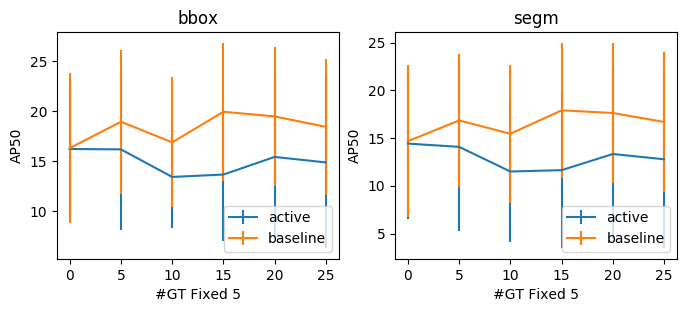

In [2]:
print('alpha - overall mean and var')

# compare(
# #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-11-2021/20:14:39',
#     '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-11-2021/11:46:08', 
#     '/checkpoint/aszlam/jobs/active_vision/pipeline/apartment_0/default/no_noise/09-11-2021/12:44:01', 
#     20, [5,10,15,20,25], [8], act_pref='default', metric='alpha', xlabel=f'#P {2}', num_samples=3
# )

compare(
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-11-2021/20:14:39',
#     '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-11-2021/11:46:08', 
#     '/checkpoint/aszlam/jobs/active_vision/pipeline/apartment_0/default/no_noise/09-11-2021/12:44:01', 
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/11-11-2021/21:25:06',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/noise/11-11-2021/22:18:10',
    '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-11-2021/13:03:17',
    '/checkpoint/aszlam/jobs/active_vision/pipeline/apartment_0/default/no_noise/12-11-2021/13:19:48',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-11-2021/01:12:01',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/12-11-2021/01:11:39',
#     '/checkpoint/aszlam/jobs/active_vision/pipeline/apartment_0/default/no_noise/09-11-2021/12:44:01', 
    50, [5], [0,5,10,15,20,25], act_pref='default', metric='alpha', xlabel=f'#GT Fixed {5}', num_samples=3
)
